In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.distributions as D
from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture


In [11]:
def p(x):
    """
    Compute the unnormalized target density function p(x).
    """
    exp_component = np.exp(-0.5 * x**2)
    sinusoidal_component = np.sin(x) ** 2 + 3 * np.cos(x) ** 2 * np.sin(7 * x) ** 2 + 1
    px = exp_component * sinusoidal_component
    # Set p(x) = 0 outside the interval [-3, 3]
    px = np.where(np.abs(x) <= 3, px, 0.0)
    return px


In [3]:
# Step 1: Prepare data and fit the GMM to approximate p(x)

# Generate a fine grid within [-3, 3]
x_grid = np.linspace(-3, 3, 1000)
px_values = p(x_grid)

# Normalize p(x) to create a proper probability density function
dx = x_grid[1] - x_grid[0]
area_under_px = np.sum(px_values) * dx
px_normalized = px_values / area_under_px

# Inverse transform sampling to generate samples from p(x)
# Compute the cumulative distribution function (CDF)
cdf_px = np.cumsum(px_normalized) * dx
cdf_px = cdf_px / cdf_px[-1]  # Normalize to [0,1]

# Create an interpolator for the inverse CDF
inverse_cdf_px = interp1d(
    cdf_px, x_grid, bounds_error=False, fill_value=(x_grid[0], x_grid[-1])
)

# Generate random samples from p(x)
np.random.seed(42)
num_samples_p = 10000
uniform_random_numbers = np.random.rand(num_samples_p)
samples_p = inverse_cdf_px(uniform_random_numbers)

# Fit a Gaussian Mixture Model to the samples from p(x)
n_components = 5  # Adjust the number of components as needed
gmm = GaussianMixture(
    n_components=n_components, covariance_type="full", random_state=42
)
gmm.fit(samples_p.reshape(-1, 1))


GaussianMixture(n_components=5, random_state=42)

In [4]:
gmm.means_

array([[-0.75781284],
       [ 0.7497692 ],
       [ 1.57317642],
       [-1.56953488],
       [-0.00205329]])

In [8]:
gmm.covariances_

array([[[0.10338166]],

       [[0.09843442]],

       [[0.23565411]],

       [[0.2537707 ]],

       [[0.09891491]]])

In [7]:
gmm.weights_

array([0.21679574, 0.20457637, 0.10396483, 0.11074413, 0.36391893])

In [65]:
# Mixture weights for the two components
mixture_weights = torch.tensor(
    [0.21679574, 0.20457637, 0.10396483, 0.11074413, 0.36391893]
)
mix = D.Categorical(mixture_weights)

# Means of the two Gaussian components
means = torch.tensor([-0.75781284, 0.7497692, 1.57317642, -1.56953488, -0.00205329])

# Covariance matrices (identity matrices for both components)
scales = torch.tensor(
    [
        # 0.10338166,  # Mean of the first component
        # 0.09843442,  # Mean of the second component
        # 0.23565411,
        # 0.2537707,
        # 0.09891491,
        np.sqrt(0.10338166),  # Mean of the first component
        np.sqrt(0.09843442),  # Mean of the second component
        np.sqrt(0.23565411),
        np.sqrt(0.2537707),
        np.sqrt(0.09891491),
    ]
)

# Create the multivariate normal distributions for each component
components = D.Normal(loc=means, scale=scales)

gmm2 = D.MixtureSameFamily(mix, components)
sample = gmm2.sample((100000,))

In [61]:
def importance_sampling(mixtureSameFamily, target, num_samples):
    # Step 2: Use the GMM as the proposal distribution q(x) to generate samples
    # num_samples_q = 100
    samples = mixtureSameFamily.sample((num_samples,))
    samples = samples.flatten()

    # Step 3: Compute importance weights w(x) = p(x) / q(x)
    # Evaluate p(x) at the sampled points
    px_at_samples_q = target(samples)

    # Evaluate q(x) using the GMM's PDF
    log_qx = mixtureSameFamily.log_prob(samples)
    qx_at_samples_q = (np.exp(log_qx)).numpy()

    # Compute importance weights
    weights = px_at_samples_q / qx_at_samples_q

    # Handle potential numerical issues (e.g., division by zero)
    # epsilon = 1e-10
    # valid_indices = qx_at_samples_q > epsilon
    # samples_q = samples_q[valid_indices]
    # weights = weights[valid_indices]

    weights /= np.sum(weights)  # Normalize the weights

    return weights, samples.numpy()
    # px_at_samples_q = px_at_samples_q[valid_indices]
    # qx_at_samples_q = qx_at_samples_q[valid_indices]


In [47]:
# Step 2: Use the GMM as the proposal distribution q(x) to generate samples
num_samples_q = 100
samples_q = gmm2.sample((num_samples_q,))
samples_q = samples_q.flatten()

# Step 3: Compute importance weights w(x) = p(x) / q(x)
# Evaluate p(x) at the sampled points
px_at_samples_q = p(samples_q)

# Evaluate q(x) using the GMM's PDF
log_qx = gmm2.log_prob(samples_q)
qx_at_samples_q = (np.exp(log_qx)).numpy()

# Compute importance weights
weights = px_at_samples_q / qx_at_samples_q

# Handle potential numerical issues (e.g., division by zero)
epsilon = 1e-10
valid_indices = qx_at_samples_q > epsilon
samples_q = samples_q[valid_indices]
weights = weights[valid_indices]

weights /= np.sum(weights)  # Normalize the weights

px_at_samples_q = px_at_samples_q[valid_indices]
qx_at_samples_q = qx_at_samples_q[valid_indices]


In [66]:
# Step 4: Estimate the expectation E_p[f(x)] using importance sampling
# Example: Estimate the mean E_p[x] and variance E_p[(x - E_p[x])^2]

# Estimate E_p[x]
# f_x = samples_q.numpy()  # f(x) = x

weights, samples = importance_sampling(gmm2, p, 10000)

estimated_mean = np.sum(weights * samples**2)
print(f"Estimated E_p[x]: {estimated_mean:.4f}")


Estimated E_p[x]: 0.9058


In [67]:
trials = 100
number_of_samples = [10, 100, 1000]
data = []
for trial in range(trials):
    for n_samples in number_of_samples:
        weights, samples = importance_sampling(gmm2, p, num_samples=n_samples)
        estimator = np.sum(weights * samples**2)
        # Create a string representation of q
        q_repr = "importance sampling norm"
        data.append(
            {
                "trial": trial,
                "samples": n_samples,
                "sampling method": q_repr,
                "estimator": estimator,
            }
        )

In [68]:
df = pd.DataFrame(data)

# Compute mean and standard deviation for each combination of n_samples and q
grouped = df.groupby(["samples", "sampling method"])["estimator"].agg(["mean", "std"])


print(grouped)

                                      mean       std
samples sampling method                             
10      importance sampling norm  0.908736  0.507074
100     importance sampling norm  0.892854  0.145352
1000    importance sampling norm  0.913234  0.046188


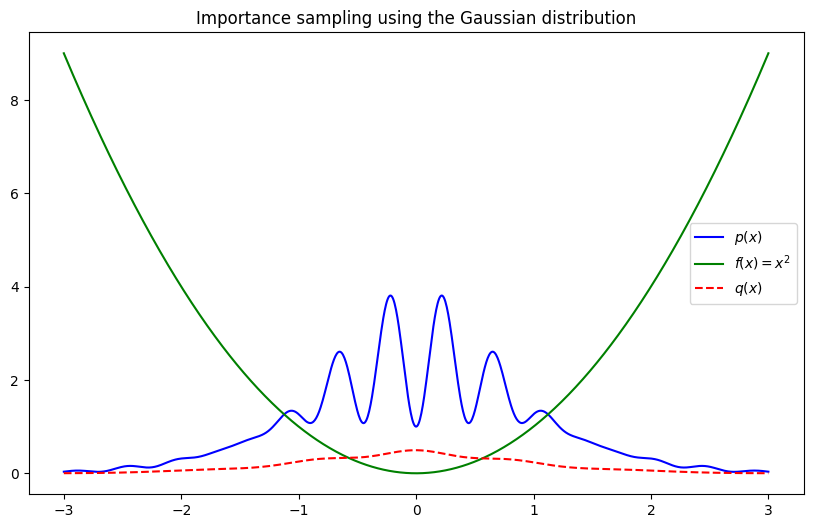

In [74]:
x = np.linspace(-3, 3, 1000)
px = p(x)
fx = x**2
logprob_q = gmm2.log_prob(torch.tensor(x))
qx = np.exp(logprob_q).numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(x, px, label="$p(x)$", color="blue")
ax.plot(x, fx, label="$f(x)=x^2$", color="green")
ax.plot(x, qx, label="$q(x)$", color="red", linestyle="--")
ax.set_title("Importance sampling using the Gaussian distribution")
plt.legend(loc="best")
# if save_fig:
#     plt.savefig("importance_sampling.png", dpi=600)
plt.show()

# # Plot the results
# # Plot the normalized p(x)
# plt.figure(figsize=(12, 6))
# plt.plot(x_grid, px_normalized, label="$p(x)$ (normalized)", linewidth=2)

# # Plot the GMM approximation q(x)
# x_gmm = np.linspace(-3, 3, 1000)

# plt.plot(x_gmm, qx_values, label="$q(x)$ (GMM)", linestyle="--", color="red")

# # Plot histogram of samples from q(x) weighted by the importance weights
# plt.hist(
#     samples_q,
#     bins=50,
#     density=True,
#     weights=weights,
#     alpha=0.5,
#     color="green",
#     label="Weighted samples from $q(x)$",
# )

# # Customize the plot
# plt.title("Importance Sampling Using GMM as the Proposal Distribution")
# plt.xlabel("$x$")
# plt.ylabel("Density")
# plt.legend()
# plt.grid(True)

# # Display the plot
# plt.show()

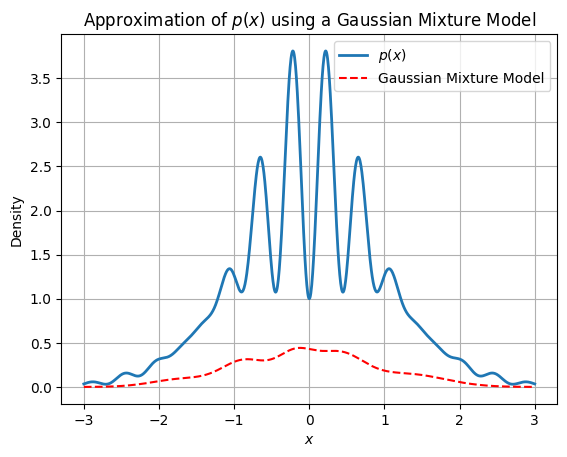

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture


def p(x):
    """
    Compute the unnormalized target density function p(x).
    """
    # Calculate the components of p(x)
    exp_component = np.exp(-0.5 * x**2)
    sinusoidal_component = np.sin(x) ** 2 + 3 * np.cos(x) ** 2 * np.sin(7 * x) ** 2 + 1
    px = exp_component * sinusoidal_component

    # Set p(x) = 0 outside the interval [-3, 3]
    px = np.where(np.abs(x) <= 3, px, 0.0)
    return px


# Generate an array of x values within the interval [-3, 3]
x = np.linspace(-3, 3, 1000)
px = p(x)

# Normalize p(x) to create a valid probability density function
dx = x[1] - x[0]  # Compute the step size
area = np.sum(px) * dx
px_normalized = px / area

# Sample data from the distribution
# We'll use the cumulative distribution function (CDF) to perform inverse transform sampling
cdf = np.cumsum(px_normalized) * dx
cdf = cdf / cdf[-1]  # Normalize the CDF to range from 0 to 1

# Create an interpolator for the inverse CDF
from scipy.interpolate import interp1d

inverse_cdf = interp1d(cdf, x)

# Generate random samples using inverse transform sampling
np.random.seed(42)  # For reproducibility
u = np.random.rand(1000)
samples = inverse_cdf(u)

# Fit a Gaussian Mixture Model to the samples
n_components = 5  # Number of Gaussian components (adjust as needed)
gmm = GaussianMixture(
    n_components=n_components, covariance_type="full", random_state=42
)
gmm.fit(samples.reshape(-1, 1))

# Generate points to plot the GMM PDF
x_gmm = np.linspace(-3, 3, 1000)
logprob = gmm.score_samples(x_gmm.reshape(-1, 1))
pdf_gmm = np.exp(logprob)

# Plot the original function p(x)
plt.plot(x, px, label="$p(x)$", linewidth=2)

# Plot the GMM approximation
plt.plot(x_gmm, pdf_gmm, label="Gaussian Mixture Model", linestyle="--", color="red")

# Customize the plot
plt.title("Approximation of $p(x)$ using a Gaussian Mixture Model")
plt.xlabel("$x$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

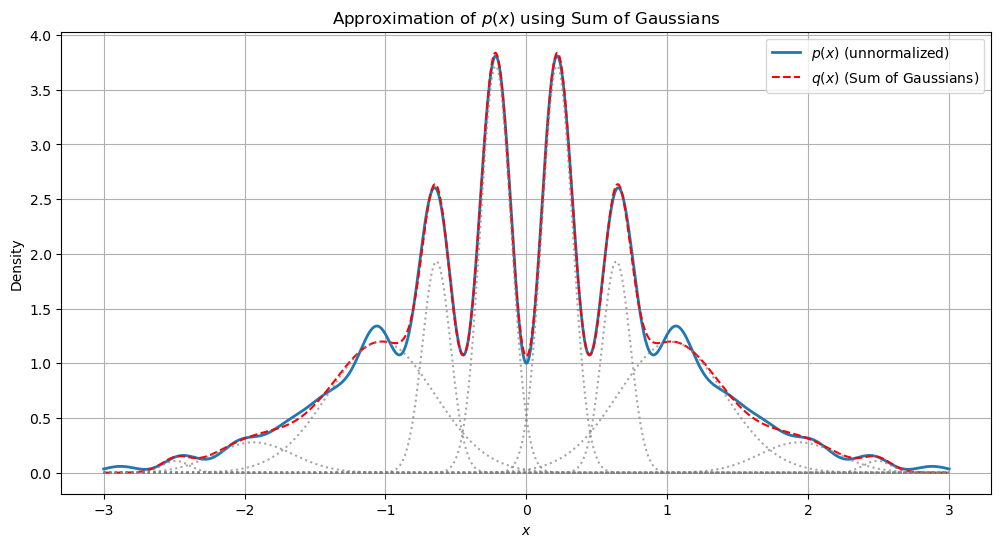

Fitted parameters for q(x):
Gaussian 1:
  Weight (w): 0.1081
  Mean (mu): -2.4902
  Sigma: 0.0989
Gaussian 2:
  Weight (w): 0.2777
  Mean (mu): -1.9354
  Sigma: 0.2795
Gaussian 3:
  Weight (w): 1.1967
  Mean (mu): -1.0288
  Sigma: 0.3744
Gaussian 4:
  Weight (w): 1.9310
  Mean (mu): -0.6384
  Sigma: 0.1001
Gaussian 5:
  Weight (w): 3.7171
  Mean (mu): -0.2178
  Sigma: 0.1090
Gaussian 6:
  Weight (w): 3.7171
  Mean (mu): 0.2178
  Sigma: 0.1090
Gaussian 7:
  Weight (w): 1.9310
  Mean (mu): 0.6384
  Sigma: 0.1001
Gaussian 8:
  Weight (w): 1.1967
  Mean (mu): 1.0288
  Sigma: 0.3744
Gaussian 9:
  Weight (w): 0.2777
  Mean (mu): 1.9354
  Sigma: 0.2795
Gaussian 10:
  Weight (w): 0.1081
  Mean (mu): 2.4902
  Sigma: 0.0989


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks


def p(x):
    """
    Compute the unnormalized target density function p(x).
    """
    exp_component = np.exp(-0.5 * x**2)
    sinusoidal_component = np.sin(x) ** 2 + 3 * np.cos(x) ** 2 * np.sin(7 * x) ** 2 + 1
    px = exp_component * sinusoidal_component
    # Set p(x) = 0 outside the interval [-3, 3]
    px = np.where(np.abs(x) <= 3, px, 0.0)
    return px


# Generate x values within [-3, 3]
x = np.linspace(-3, 3, 1000)
px = p(x)

# Step 1: Analyze p(x) to find peak positions and heights
# Use scipy's find_peaks function

# Find peaks in p(x)
peaks_indices, _ = find_peaks(px, height=0)
peak_x = x[peaks_indices]
peak_heights = px[peaks_indices]


# Step 2: Define the sum of Gaussians function
def sum_of_gaussians(x, *params):
    """
    Sum of N Gaussians.
    params: [w1, mu1, sigma1, w2, mu2, sigma2, ..., wN, muN, sigmaN]
    """
    n_gaussians = int(len(params) / 3)
    y = np.zeros_like(x)
    for i in range(n_gaussians):
        w = params[3 * i]
        mu = params[3 * i + 1]
        sigma = params[3 * i + 2]
        y += w * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return y


# Initial guess for parameters: weights, means, sigmas
initial_params = []
for i in range(len(peak_x)):
    w = peak_heights[i]
    mu = peak_x[i]
    # Estimate sigma based on neighborhood, assuming peaks are narrow
    if i == 0:
        left = 0
    else:
        left = peak_x[i] - peak_x[i - 1]
    if i == len(peak_x) - 1:
        right = 0
    else:
        right = peak_x[i + 1] - peak_x[i]
    sigma = (left + right) / 2 if (left + right) > 0 else 0.1
    sigma = max(sigma, 0.1)
    initial_params.extend([w, mu, sigma])

# Step 3: Fit the sum of Gaussians to p(x)

# Bounds for parameters to ensure positive weights and sigmas
bounds_lower = []
bounds_upper = []
for i in range(len(peak_x)):
    bounds_lower.extend([0, peak_x[i] - 0.5, 0.05])
    bounds_upper.extend([np.inf, peak_x[i] + 0.5, 1.0])

# Perform curve fitting
popt, _ = curve_fit(
    sum_of_gaussians, x, px, p0=initial_params, bounds=(bounds_lower, bounds_upper)
)

# Extract fitted parameters
n_gaussians = int(len(popt) / 3)
weights_fitted = popt[::3]
means_fitted = popt[1::3]
sigmas_fitted = popt[2::3]

# Compute the fitted q(x)
qx = sum_of_gaussians(x, *popt)

# Step 4: Plot the original p(x) and the approximate q(x)
plt.figure(figsize=(12, 6))
plt.plot(x, px, label="$p(x)$ (unnormalized)", linewidth=2)
plt.plot(x, qx, label="$q(x)$ (Sum of Gaussians)", linestyle="--", color="red")

# Plot individual Gaussians for illustration
for i in range(n_gaussians):
    gaussian_i = weights_fitted[i] * np.exp(
        -0.5 * ((x - means_fitted[i]) / sigmas_fitted[i]) ** 2
    )
    plt.plot(x, gaussian_i, linestyle=":", color="gray", alpha=0.7)

# Customize the plot
plt.title("Approximation of $p(x)$ using Sum of Gaussians")
plt.xlabel("$x$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Optional: Print the fitted parameters
print("Fitted parameters for q(x):")
for i in range(n_gaussians):
    print(f"Gaussian {i+1}:")
    print(f"  Weight (w): {weights_fitted[i]:.4f}")
    print(f"  Mean (mu): {means_fitted[i]:.4f}")
    print(f"  Sigma: {sigmas_fitted[i]:.4f}")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks


def p(x):
    """
    Compute the unnormalized target density function p(x).
    """
    exp_component = np.exp(-0.5 * x**2)
    sinusoidal_component = np.sin(x) ** 2 + 3 * np.cos(x) ** 2 * np.sin(7 * x) ** 2 + 1
    px = exp_component * sinusoidal_component
    # Set p(x) = 0 outside the interval [-3, 3]
    px = np.where(np.abs(x) <= 3, px, 0.0)
    return px


# Generate x values within [-3, 3]
x = np.linspace(-3, 3, 1000)
px = p(x)

# Step 1: Analyze p(x) to find peak positions and heights
from scipy.signal import find_peaks

# Find peaks in p(x)
peaks_indices, _ = find_peaks(px, height=0)
peak_x = x[peaks_indices]
peak_heights = px[peaks_indices]


# Step 2: Define the sum of Gaussians function
def sum_of_gaussians(x, *params):
    """
    Sum of N Gaussians.
    params: [w1, mu1, sigma1, w2, mu2, sigma2, ..., wN, muN, sigmaN]
    """
    n_gaussians = int(len(params) / 3)
    y = np.zeros_like(x)
    for i in range(n_gaussians):
        w = params[3 * i]
        mu = params[3 * i + 1]
        sigma = params[3 * i + 2]
        y += w * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return y


# Initial guess for parameters: weights, means, sigmas
initial_params = []
for i in range(len(peak_x)):
    w = peak_heights[i]
    mu = peak_x[i]
    # Estimate sigma based on neighborhood
    if i == 0:
        left = 0
    else:
        left = peak_x[i] - peak_x[i - 1]
    if i == len(peak_x) - 1:
        right = 0
    else:
        right = peak_x[i + 1] - peak_x[i]
    sigma = (left + right) / 2 if (left + right) > 0 else 0.1
    sigma = max(sigma, 0.1)
    initial_params.extend([w, mu, sigma])

# Step 3: Fit the sum of Gaussians to p(x)
from scipy.optimize import curve_fit

# Bounds for parameters
bounds_lower = []
bounds_upper = []
for i in range(len(peak_x)):
    bounds_lower.extend([0, peak_x[i] - 0.5, 0.05])
    bounds_upper.extend([np.inf, peak_x[i] + 0.5, 1.0])

# Perform curve fitting
popt, _ = curve_fit(
    sum_of_gaussians, x, px, p0=initial_params, bounds=(bounds_lower, bounds_upper)
)

# Extract fitted parameters
n_gaussians = int(len(popt) / 3)
weights_fitted = popt[::3]
means_fitted = popt[1::3]
sigmas_fitted = popt[2::3]

# Compute the fitted q(x)
qx = sum_of_gaussians(x, *popt)


In [ ]:
# Step 4: Sample from q(x)
def sample_from_q(num_samples, weights, means, sigmas):
    """
    Generate samples from the sum of Gaussians q(x).
    """

    samples = []
    # Choose components based on normalized weights
    component_choices = np.random.choice(len(weights), size=num_samples, p=weights)
    for idx in component_choices:
        mu = means[idx]
        sigma = sigmas[idx]
        sample = np.random.normal(mu, sigma)
        samples.append(sample)
    return np.array(samples)


# Normalize the weights for sampling
weights_normalized = weights_fitted / np.sum(weights_fitted)

# Generate samples from q(x)
# np.random.seed(42)
num_samples_q = 100000
samples_q = sample_from_q(
    num_samples_q, weights_normalized, means_fitted, sigmas_fitted
)

# Step 5: Compute importance weights w(x) = p(x) / q(x)
# Evaluate p(x) at the sampled points
px_at_samples_q = p(samples_q)

# Evaluate q(x) at the sampled points
qx_at_samples_q = sum_of_gaussians(samples_q, *popt)

# Compute importance weights
weights = px_at_samples_q / qx_at_samples_q
weights /= np.sum(weights)  # Normalize the weights
# Handle potential numerical issues
epsilon = 1e-10
valid_indices = (qx_at_samples_q > epsilon) & (px_at_samples_q > 0)
samples_q_valid = samples_q[valid_indices]
weights_valid = weights[valid_indices]
px_at_samples_q_valid = px_at_samples_q[valid_indices]
qx_at_samples_q_valid = qx_at_samples_q[valid_indices]

# Step 6: Estimate expectations under p(x)
# Example: Estimate E_p[x] and Var_p[x]

# Estimate E_p[x]
f_x = qx_at_samples_q_valid  # f(x) = x
estimated_mean = np.sum(weights_valid * f_x**2)  # / np.sum(weights_valid)
print(f"Estimated E_p[x]: {estimated_mean:.4f}")


Estimated E_p[x]: 6.1331


Estimated E_p[x]: 1.1322
Estimated Var_p[x]: -0.1497


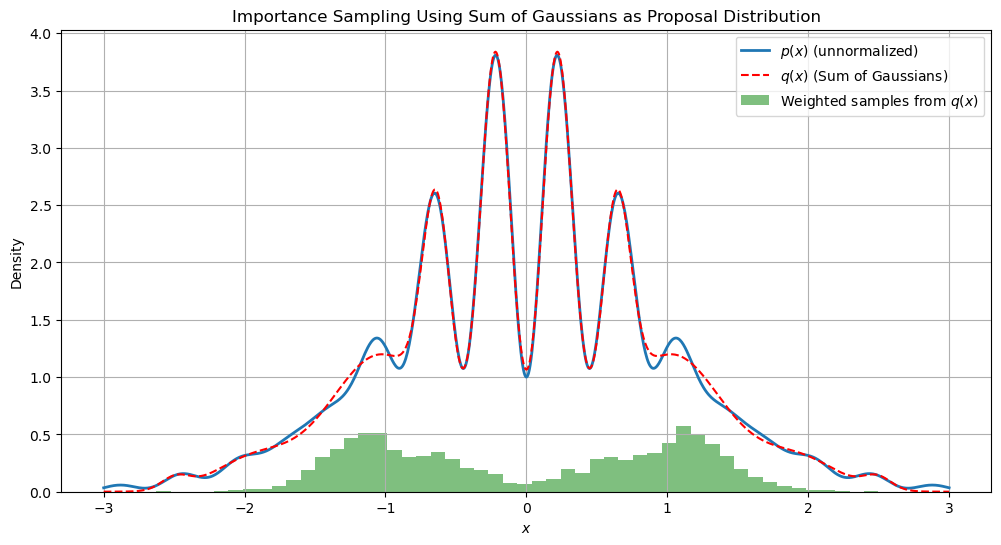

In [39]:
# Estimate E_p[x^2]
f_x2 = samples_q_valid**2  # f(x) = x^2
estimated_mean_square = np.sum(weights_valid * f_x2) / np.sum(weights_valid)

# Compute the estimated variance Var_p[x] = E_p[x^2] - (E_p[x])^2
estimated_variance = estimated_mean_square - estimated_mean**2

print(f"Estimated E_p[x]: {estimated_mean:.4f}")
print(f"Estimated Var_p[x]: {estimated_variance:.4f}")

# Step 7: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x, px, label="$p(x)$ (unnormalized)", linewidth=2)
plt.plot(x, qx, label="$q(x)$ (Sum of Gaussians)", linestyle="--", color="red")

# Plot histogram of weighted samples
plt.hist(
    samples_q_valid,
    bins=50,
    density=True,
    weights=weights_valid,
    alpha=0.5,
    color="green",
    label="Weighted samples from $q(x)$",
)

# Customize the plot
plt.title("Importance Sampling Using Sum of Gaussians as Proposal Distribution")
plt.xlabel("$x$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()